# Knowledge Graph

In NLP, a knowledge graph is one of the most fundemental things to know. It allows us to visualize the relationships between the words in the vocabulary. The formal definition of a knowledge graph is a directed labeled graph in which we have associated domain specific meanings with nodes and edges. A relationship between node A, edge E, and Node B in which E is going from A to B can be described as A relates to B because E.

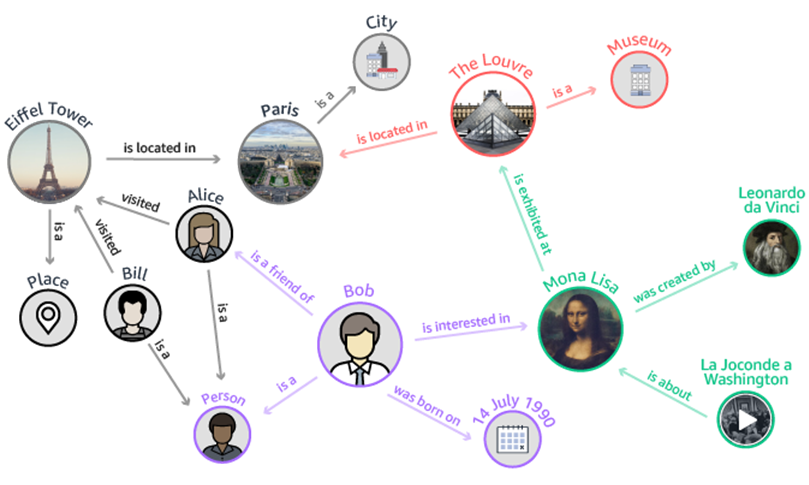

Above is a simple example of a knowledge graph. It shows multiple people, their. interests and how they are all related to eachother. Let's take a look at the "Mona Lisa" node. In this knowledge graph, there are 4 edges involving this node, 2 of which are leaving and 2 which are incoming. Something that the Knowledge graph tells us is that the "Mona Lisa"(A) "is an exhibit at"(E) "The Louvre"(B).

### Real-World Applications

One example of a knowledge graph in use can be seen when doing a Google Search. 

![Boeing Search Result](BoeingSearch.png)

While searching for the company Boeing, based on the many results and similar results and the knowledge graph that has been built by the Google Search Engine. Some of the searches that can be easily found are the link to Boeing's company site and its popular subpages. There are also questions that are frequently asked such as "Is Boeing the biggest company in the world?" which in the knowledge graph might have a strong connection. In addition, other airline and defense companies are found on the right, below Google's description of Boeing from Wikipedia, which include Airbus, Lockheed Martin, Northrop Grumman, and SpaceX.

The way that all of these topics are related have been found through the frequent number of searches and their following searches. Similar companies to Boeing were found, their connection in a knowledge graph would likely be "company". Location's part of the search may have "has buildings" or something similar as its connection. The news articles shown would have the connection of "is mentioned" to Boeing.

We can do this with each and every search Google does. However, today we won't be focusing on Google, instead let's set our sights to their competitor's, Amazon.

### Amazon Alexa Reviews Dataset

This dataset takes over 3000 reviews on Amazon Products and has multiple categories such as the date, number of stars, the text reviews itself, etc. What we are looking at today are the text reviews. Let's see how each word that is commonly used while writing reviews relates to one another.

You can find the dataset [here](https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews).

### Install Packages

In [1]:
!pip install --upgrade scipy=='1.7.1' networkx=='2.6.3'


import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

spacyModel = spacy.load('en_core_web_sm')

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

### Keep Only Sentences

In [2]:
sentences = pd.read_csv('amazon_alexa.tsv', sep='\t')['verified_reviews']
sentences.sample(5)

2279                                                                                                                                                              Works great to watch youtube and amazin video
2346                                                                                                                                                                           amazon fire stick is amazing !!!
3054    I love my Dot and am hoping to add a couple more around the apartment. The only reason I didn't give it 5 stars is because I wish the speaker would be just a little better. I know Amazon probably ...
2171    The selection is wonderful and the ease of use on the home page is nice. I wish, however, it didn't keep overcoming my settings for my other devices attached to my TV.  I have to keep switching ba...
762                                                                                                                                                                     

### Create the Entities

In [3]:
def get_entities(sent):
    
  sent = sent.strip()

  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in spacyModel(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [11]:
entity_pairs = []

for i in tqdm(sentences):
    entity_pair = get_entities(i)
    #if (len(entity_pair[0])==0 or len(entity_pair[1])==0):
    #    continue
    entity_pairs.append(entity_pair)

  0%|          | 0/3150 [00:00<?, ?it/s]

2072

### Create Entity Relations

In [17]:
def get_relation(sent):
    doc = spacyModel(sent)

    # Matcher class object 
    matcher = Matcher(spacyModel.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern]) 

    matches = matcher(doc)
    k = len(matches) - 1
    if k < 0:
        return None

    span = doc[matches[k][0]:matches[k][2]] 

    return(span.text)

In [20]:
relations = [get_relation(i) for i in tqdm(sentences)]

  0%|          | 0/3150 [00:00<?, ?it/s]

In [23]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

3069


ValueError: All arrays must be of the same length

### Create a Directed-Graph

In [ ]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

### Smaller Graphs

#### Sources

<sub>https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/</sub>    
<sub>https://aws.amazon.com/neptune/knowledge-graphs-on-aws/</sub>    
<sub>http://ai.stanford.edu/blog/introduction-to-knowledge-graphs/</sub>    